<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 16:56:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 9.2 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 170 kB 59.2 MB/s 
     |████████████████████████████████| 133 kB 57.8 MB/s 
     |████████████████████████████████| 138 kB 52.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: bdidrijc
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/bdidrijc


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 3zvs65in with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 36s 79ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1518 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1564
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0632 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1415
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0541 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1471
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0573 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1174
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_err

epoch,51
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.03236
val_loss,0.01004
val_mean_squared_error,0.01004
val_mean_absolute_error,0.07596
_runtime,51
_timestamp,1626886690
_step,51
best_val_loss,0.00991


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁
val_loss,█▆▇▃▃▂▂▃▂▂▂▂▃▁▂▁▂▂▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁
val_mean_squared_error,█▆▇▃▃▂▂▃▂▂▂▂▃▁▂▁▂▂▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁
val_mean_absolute_error,█▇▇▅▄▃▃▄▃▃▃▂▃▂▃▂▂▃▁▂▃▂▁▁▁▁▂▃▂▁▁▁▁▁▂▁▁▁▃▁
_runtime,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fs4d8zp3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 114ms/step - loss: 3.9570 - mean_squared_error: 3.9570 - mean_absolute_error: 1.0675 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1571
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0638 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1544
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0622 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1369
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0579 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1358
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0405 - mean_squared_error: 0.0405 - me

epoch,45
loss,0.00289
mean_squared_error,0.00289
mean_absolute_error,0.04074
val_loss,0.03321
val_mean_squared_error,0.03321
val_mean_absolute_error,0.14928
_runtime,11
_timestamp,1626886725
_step,45
best_val_loss,0.01561


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▃▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▂▂█▂▅▃▃▂▂▂▃▂▁▁▁▂▁▃▁▂▁▁▂▂▁▁▂▂▁▁▁▁▂▂▁▂▂▁
val_mean_squared_error,▃▃▂▂█▂▅▃▃▂▂▂▃▂▁▁▁▂▁▃▁▂▁▁▂▂▁▁▂▂▁▁▁▁▂▂▁▂▂▁
val_mean_absolute_error,▄▄▃▃█▂▅▄▃▂▃▂▄▂▁▁▂▃▁▄▂▂▂▁▂▃▁▁▂▃▁▁▂▂▃▂▁▂▂▁
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: u5bqzdoe with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 61ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1416 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1503
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0593 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1336
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0470 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1196
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0501 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1299
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,62
loss,0.00163
mean_squared_error,0.00163
mean_absolute_error,0.03011
val_loss,0.01473
val_mean_squared_error,0.01473
val_mean_absolute_error,0.09617
_runtime,17
_timestamp,1626886754
_step,62
best_val_loss,0.00959


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▂▃▁▂▂▂▂▂▁▂▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▃▃▇▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▃▁▁▁▁▂▂▁▁▁▂▁▁▁▁▃▁▁▂
val_mean_squared_error,█▅▆▃▃▇▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▃▁▁▁▁▂▂▁▁▁▂▁▁▁▁▃▁▁▂
val_mean_absolute_error,█▆▆▄▃▇▃▂▃▂▂▃▂▂▃▃▂▁▁▁▁▄▁▁▂▁▂▃▁▂▁▃▁▁▁▂▄▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: lr9vie43 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 56ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - mean_absolute_error: 0.2050 - val_loss: 0.0650 - val_mean_squared_error: 0.0650 - val_mean_absolute_error: 0.2029
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0910 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1196
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0687 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1703
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0797 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1102
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_erro

epoch,43
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.02987
val_loss,0.01141
val_mean_squared_error,0.01141
val_mean_absolute_error,0.07992
_runtime,14
_timestamp,1626886782
_step,43
best_val_loss,0.00973


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▂▃▂▃▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▂▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▆▁▁▁▁▁▁
val_mean_squared_error,█▂▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▆▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▃▁▁▁▁▂▁▁▁▁▂▁▇▁▂▂▁▂▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j77fechq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 80ms/step - loss: 0.0852 - mean_squared_error: 0.0852 - mean_absolute_error: 0.2501 - val_loss: 0.0727 - val_mean_squared_error: 0.0727 - val_mean_absolute_error: 0.2320
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0901 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1602
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0860 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1575
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0822 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1637
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0104 - mean_squared_erro

epoch,199
loss,0.00339
mean_squared_error,0.00339
mean_absolute_error,0.0429
val_loss,0.01939
val_mean_squared_error,0.01939
val_mean_absolute_error,0.11513
_runtime,38
_timestamp,1626886827
_step,199
best_val_loss,0.01937


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 30septc3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 114ms/step - loss: 0.0984 - mean_squared_error: 0.0984 - mean_absolute_error: 0.2470 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1568
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1427 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1613
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0715 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1695
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0635 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1473
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079

epoch,199
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.03368
val_loss,0.0155
val_mean_squared_error,0.0155
val_mean_absolute_error,0.09608
_runtime,27
_timestamp,1626886870
_step,199
best_val_loss,0.01547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h5xbfub4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 3s 31ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - mean_absolute_error: 0.2087 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1663
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0704 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1493
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0614 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1485
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0572 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1420
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_squared_erro

epoch,199
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.03155
val_loss,0.0128
val_mean_squared_error,0.0128
val_mean_absolute_error,0.08619
_runtime,52
_timestamp,1626886949
_step,199
best_val_loss,0.01277


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qt92kqv2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 115ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - mean_absolute_error: 0.2147 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1898
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1095 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1550
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0767 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1483
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0634 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1514
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066

epoch,99
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02832
val_loss,0.00933
val_mean_squared_error,0.00933
val_mean_absolute_error,0.07224
_runtime,18
_timestamp,1626886975
_step,99
best_val_loss,0.00925


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kbv68s6o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 4s 32ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1316 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1340
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0679 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1172
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0652 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1159
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0576 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1024
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_squared_error: 0.

epoch,49
loss,0.00188
mean_squared_error,0.00188
mean_absolute_error,0.03325
val_loss,0.01299
val_mean_squared_error,0.01299
val_mean_absolute_error,0.08841
_runtime,18
_timestamp,1626887002
_step,49
best_val_loss,0.00996


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▃▂▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▃▂▄▃▅█▂▂▁▁▃▁▂▁▁▁▂▁▁▁▁▁▂▂▂▁▁▃▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▄▃▃▂▄▃▅█▂▂▁▁▃▁▂▁▁▁▂▁▁▁▁▁▂▂▂▁▁▃▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▅▄▄▃▄▃▆█▂▂▁▁▄▁▃▁▁▁▂▁▂▁▁▁▂▂▃▁▁▄▁▁▁▂▁▂▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: iuerdt33 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 60ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1548 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1518
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0820 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1363
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0530 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1255
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0482 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1172
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_erro

epoch,55
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02763
val_loss,0.0099
val_mean_squared_error,0.0099
val_mean_absolute_error,0.07547
_runtime,16
_timestamp,1626887036
_step,55
best_val_loss,0.00926


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▇▆▄▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kxm6db7p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 4s 87ms/step - loss: 0.1103 - mean_squared_error: 0.1103 - mean_absolute_error: 0.2858 - val_loss: 0.1056 - val_mean_squared_error: 0.1056 - val_mean_absolute_error: 0.2745
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1225 - val_loss: 0.0502 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1854
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0879 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1658
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0946 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1681
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0145 - mean_squared_erro

epoch,99
loss,0.00506
mean_squared_error,0.00506
mean_absolute_error,0.05261
val_loss,0.02832
val_mean_squared_error,0.02832
val_mean_absolute_error,0.13772
_runtime,24
_timestamp,1626887070
_step,99
best_val_loss,0.02832


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ksvk8495 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 3s 31ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - mean_absolute_error: 0.2663 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1644
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0830 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1533
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0761 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1574
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0728 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1557
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0084 - mean_squared_erro

epoch,99
loss,0.00358
mean_squared_error,0.00358
mean_absolute_error,0.04405
val_loss,0.02003
val_mean_squared_error,0.02003
val_mean_absolute_error,0.11713
_runtime,32
_timestamp,1626887111
_step,99
best_val_loss,0.02003


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nnukiiv8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 4s 60ms/step - loss: 0.1378 - mean_squared_error: 0.1378 - mean_absolute_error: 0.2300 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1717
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0819 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1366
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0971 - val_loss: 0.0573 - val_mean_squared_error: 0.0573 - val_mean_absolute_error: 0.2017
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0909 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - val_mean_absolute_error: 0.1978
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0149 - mean_squared_error: 0.

epoch,49
loss,0.0022
mean_squared_error,0.0022
mean_absolute_error,0.03543
val_loss,0.00995
val_mean_squared_error,0.00995
val_mean_absolute_error,0.07402
_runtime,15
_timestamp,1626887136
_step,49
best_val_loss,0.00995


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄██▂▂▃▃▂▂▂▄▂▂▂▁▁▂▁▁▄▂▁▁▁▁▁▃▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▅▄██▂▂▃▃▂▂▂▄▂▂▂▁▁▂▁▁▄▂▁▁▁▁▁▃▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▆▄██▃▃▄▄▃▂▂▅▂▂▂▁▂▂▂▂▅▂▂▂▁▂▂▃▂▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cefmgyiy with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 32ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1623 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1219
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0505 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1093
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0403 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0977
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0373 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0912
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,24
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.02974
val_loss,0.00953
val_mean_squared_error,0.00953
val_mean_absolute_error,0.07325
_runtime,14
_timestamp,1626887160
_step,24
best_val_loss,0.00937


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▂▂▂▁▁▃▁▃▁▂▁▁▁▂▁▂▁▁▁
val_mean_squared_error,█▆▄▄▃▃▂▂▂▁▁▃▁▃▁▂▁▁▁▂▁▂▁▁▁
val_mean_absolute_error,█▆▅▄▃▂▂▂▂▁▁▃▁▃▁▂▁▁▁▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: nfwr4jp1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 58ms/step - loss: 0.1228 - mean_squared_error: 0.1228 - mean_absolute_error: 0.2305 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_mean_absolute_error: 0.2299
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1128 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1297
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.0984 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1283
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0673 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1218
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0094 - mean_squared_error: 0.

epoch,49
loss,0.0019
mean_squared_error,0.0019
mean_absolute_error,0.03303
val_loss,0.01179
val_mean_squared_error,0.01179
val_mean_absolute_error,0.08334
_runtime,16
_timestamp,1626887185
_step,49
best_val_loss,0.0096


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▄▃▃▄▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▃▂▂▂▁▁▂▁▂▂▂▁▁▂▁▁▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▃▂▂▂▁▁▂▁▂▂▂▁▁▂▁▁▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▄▃▂▂▂▂▃▂▂▂▃▁▁▂▁▁▂▁▁▂▂▁▂▁▃▂▁▂▁▁▂▁▁▁▂▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cxiei6if with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 122ms/step - loss: 3.0794 - mean_squared_error: 3.0794 - mean_absolute_error: 0.9275 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1618
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0663 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1536
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0610 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1528
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0593 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1402
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0068

epoch,25
loss,0.00663
mean_squared_error,0.00663
mean_absolute_error,0.06315
val_loss,0.02129
val_mean_squared_error,0.02129
val_mean_absolute_error,0.1208
_runtime,11
_timestamp,1626887205
_step,25
best_val_loss,0.01853


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▃▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▂█▂▃▁▇▁▁▅▂▁▁▁▁▁▁▂▁▁▁▂▁▁
val_mean_squared_error,▂▂▂▂█▂▃▁▇▁▁▅▂▁▁▁▁▁▁▂▁▁▁▂▁▁
val_mean_absolute_error,▃▃▃▂█▂▄▂█▁▁▆▂▁▁▁▁▂▁▂▁▂▁▂▂▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅███████████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅███████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: o4ds9knm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 3s 32ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - mean_absolute_error: 0.2066 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1561
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0774 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1626
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0678 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1624
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0628 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1562
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0071 - mean_squared_erro

epoch,199
loss,0.00217
mean_squared_error,0.00217
mean_absolute_error,0.0346
val_loss,0.01523
val_mean_squared_error,0.01523
val_mean_absolute_error,0.09608
_runtime,53
_timestamp,1626887269
_step,199
best_val_loss,0.01519


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2lj06lrn with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 117ms/step - loss: 0.2693 - mean_squared_error: 0.2693 - mean_absolute_error: 0.3363 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1473
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0725 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1448
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0650 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1492
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1002 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1249
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041

epoch,59
loss,0.00207
mean_squared_error,0.00207
mean_absolute_error,0.03425
val_loss,0.01368
val_mean_squared_error,0.01368
val_mean_absolute_error,0.09212
_runtime,15
_timestamp,1626887332
_step,59
best_val_loss,0.01039


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▂▃▁▁▂▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,██▄▅▃▃▃▃▃▂▃▂▂▂▂▅▂▂▂▂▂▃▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▂▂▂
val_mean_squared_error,██▄▅▃▃▃▃▃▂▃▂▂▂▂▅▂▂▂▂▂▃▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▂▂▂
val_mean_absolute_error,██▆▆▅▄▄▄▄▃▄▃▂▃▂▆▂▂▃▃▂▃▂▂▂▂▁▂▁▂▁▂▁▁▂▂▁▂▃▂
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nhaejp2d with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 63ms/step - loss: 0.0644 - mean_squared_error: 0.0644 - mean_absolute_error: 0.2052 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1629
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0707 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1495
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0610 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1484
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0584 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1434
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_erro

epoch,99
loss,0.00219
mean_squared_error,0.00219
mean_absolute_error,0.0349
val_loss,0.0156
val_mean_squared_error,0.0156
val_mean_absolute_error,0.0956
_runtime,26
_timestamp,1626887369
_step,99
best_val_loss,0.0156


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1q5cgdap with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 3s 30ms/step - loss: 0.0652 - mean_squared_error: 0.0652 - mean_absolute_error: 0.2085 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1620
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0744 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1555
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0706 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1576
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0686 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1567
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_erro

epoch,199
loss,0.00277
mean_squared_error,0.00277
mean_absolute_error,0.03912
val_loss,0.01851
val_mean_squared_error,0.01851
val_mean_absolute_error,0.11001
_runtime,58
_timestamp,1626887443
_step,199
best_val_loss,0.01851


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u82v82oj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 57ms/step - loss: 2.7672 - mean_squared_error: 2.7672 - mean_absolute_error: 0.7391 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1589
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0648 - val_loss: 0.0540 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.1772
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0577 - mean_squared_error: 0.0577 - mean_absolute_error: 0.2038 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1239
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0997 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1225
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0

epoch,30
loss,0.00446
mean_squared_error,0.00446
mean_absolute_error,0.05016
val_loss,0.01813
val_mean_squared_error,0.01813
val_mean_absolute_error,0.1071
_runtime,14
_timestamp,1626887468
_step,30
best_val_loss,0.01597


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▃▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▄▁▁▆█▃▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▄▁▁▆█▃▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▄▂▂▆█▄▂▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: c9suq23i with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 33ms/step - loss: 0.2951 - mean_squared_error: 0.2951 - mean_absolute_error: 0.2662 - val_loss: 0.1038 - val_mean_squared_error: 0.1038 - val_mean_absolute_error: 0.2777
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1402 - val_loss: 0.0487 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1816
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1078 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1205
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0726 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1244
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0083 - mean_squared_erro

epoch,30
loss,0.00225
mean_squared_error,0.00225
mean_absolute_error,0.03481
val_loss,0.01341
val_mean_squared_error,0.01341
val_mean_absolute_error,0.09185
_runtime,16
_timestamp,1626887501
_step,30
best_val_loss,0.01021


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▁▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▄▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: ysvfhg72 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 115ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - mean_absolute_error: 0.1662 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1526
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0699 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1474
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0761 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1380
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0568 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1521
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0100 - mean_squared_error: 0.010

epoch,124
loss,0.00155
mean_squared_error,0.00155
mean_absolute_error,0.02966
val_loss,0.01009
val_mean_squared_error,0.01009
val_mean_absolute_error,0.07531
_runtime,21
_timestamp,1626887534
_step,124
best_val_loss,0.01003


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▃▃▃▂▂▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂▁▁▂
val_loss,██▄▄▃▃▂▂▂▂▃▃▂▄▃▁▂▁▁▂▁▁▁▁▁▁▃▁▁▂▁▂▁▁▁▁▁▁▂▁
val_mean_squared_error,██▄▄▃▃▂▂▂▂▃▃▂▄▃▁▂▁▁▂▁▁▁▁▁▁▃▁▁▂▁▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,██▅▅▄▄▃▃▃▃▄▄▂▅▄▂▃▂▂▂▂▁▂▁▁▁▄▁▁▂▁▂▂▁▁▁▁▁▃▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6ozr7adi with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 57ms/step - loss: 0.1283 - mean_squared_error: 0.1283 - mean_absolute_error: 0.2366 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1513
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0882 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1457
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0768 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1411
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0652 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1570
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0128 - mean_squared_erro

epoch,42
loss,0.00248
mean_squared_error,0.00248
mean_absolute_error,0.03743
val_loss,0.01427
val_mean_squared_error,0.01427
val_mean_absolute_error,0.09256
_runtime,16
_timestamp,1626887565
_step,42
best_val_loss,0.01023


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▄▄▄▃▂▃▃▂▂▂▂▁▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆▆█▇▃▇▇▃▃▂▄▆▂▄▂▃▂▃▄▁▁▂▂▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▂
val_mean_squared_error,▇▆▆█▇▃▇▇▃▃▂▄▆▂▄▂▃▂▃▄▁▁▂▂▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▇█▇▄▇▇▃▄▃▅▆▃▅▂▄▃▄▅▂▁▂▂▁▁▃▁▃▂▁▂▂▁▁▂▂▁▂▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: iwoc2vla with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 128ms/step - loss: 0.1133 - mean_squared_error: 0.1133 - mean_absolute_error: 0.2541 - val_loss: 0.0830 - val_mean_squared_error: 0.0830 - val_mean_absolute_error: 0.2497
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1442 - val_loss: 0.0509 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1654
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0988 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1610
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0804 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1400
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - 

epoch,49
loss,0.00151
mean_squared_error,0.00151
mean_absolute_error,0.0293
val_loss,0.01072
val_mean_squared_error,0.01072
val_mean_absolute_error,0.07656
_runtime,16
_timestamp,1626887594
_step,49
best_val_loss,0.01072


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wmqcnffo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 3s 32ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - mean_absolute_error: 0.1766 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1328
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0889 - val_loss: 0.0742 - val_mean_squared_error: 0.0742 - val_mean_absolute_error: 0.2196
Epoch 3/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0759 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1181
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0720 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0993
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_erro

epoch,27
loss,0.00206
mean_squared_error,0.00206
mean_absolute_error,0.03348
val_loss,0.01366
val_mean_squared_error,0.01366
val_mean_absolute_error,0.09161
_runtime,15
_timestamp,1626887624
_step,27
best_val_loss,0.00992


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▂▂▃▂▂▂▃▃▃▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ku5sgd2v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 4s 34ms/step - loss: 0.1303 - mean_squared_error: 0.1303 - mean_absolute_error: 0.3084 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.2585
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1051 - val_loss: 0.0512 - val_mean_squared_error: 0.0512 - val_mean_absolute_error: 0.1867
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0976 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1766
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0867 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1757
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0130 - mean_squared_error: 0.

epoch,49
loss,0.00633
mean_squared_error,0.00633
mean_absolute_error,0.05862
val_loss,0.03407
val_mean_squared_error,0.03407
val_mean_absolute_error,0.14986
_runtime,24
_timestamp,1626887662
_step,49
best_val_loss,0.03407


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ak2kys64 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 127ms/step - loss: 0.1611 - mean_squared_error: 0.1611 - mean_absolute_error: 0.3446 - val_loss: 0.0730 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.2220
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - mean_absolute_error: 0.1140 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1654
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1580 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1534
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0967 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1747
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - me

epoch,49
loss,0.00452
mean_squared_error,0.00452
mean_absolute_error,0.04958
val_loss,0.0248
val_mean_squared_error,0.0248
val_mean_absolute_error,0.12954
_runtime,17
_timestamp,1626887694
_step,49
best_val_loss,0.0248


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gkxb4f1y with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 4s 63ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - mean_absolute_error: 0.2995 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1951
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0971 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1550
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1031 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1734
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0772 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1741
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0117 - mean_squared_erro

epoch,199
loss,0.00264
mean_squared_error,0.00264
mean_absolute_error,0.03817
val_loss,0.01774
val_mean_squared_error,0.01774
val_mean_absolute_error,0.10768
_runtime,44
_timestamp,1626887752
_step,199
best_val_loss,0.01774


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bi67zs3y with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 4s 65ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1592 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1666
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0729 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1580
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0685 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1569
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0603 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1510
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_erro

epoch,99
loss,0.00206
mean_squared_error,0.00206
mean_absolute_error,0.03396
val_loss,0.01506
val_mean_squared_error,0.01506
val_mean_absolute_error,0.09536
_runtime,29
_timestamp,1626887794
_step,99
best_val_loss,0.01497


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qntzej71 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 87ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - mean_absolute_error: 0.2421 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1579
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1249 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1774
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0763 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1625
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1624
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0088 - mean_squared_erro

epoch,99
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.03746
val_loss,0.01754
val_mean_squared_error,0.01754
val_mean_absolute_error,0.10807
_runtime,27
_timestamp,1626887836
_step,99
best_val_loss,0.01754


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 08fu7pgc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 58ms/step - loss: 8.2070 - mean_squared_error: 8.2070 - mean_absolute_error: 1.4337 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1530
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - mean_absolute_error: 0.1507 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1624
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0977 - val_loss: 0.0665 - val_mean_squared_error: 0.0665 - val_mean_absolute_error: 0.2089
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1341 - val_loss: 0.1364 - val_mean_squared_error: 0.1364 - val_mean_absolute_error: 0.3313
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0406 - mean_squared_erro

epoch,37
loss,0.00339
mean_squared_error,0.00339
mean_absolute_error,0.04365
val_loss,0.02313
val_mean_squared_error,0.02313
val_mean_absolute_error,0.12338
_runtime,16
_timestamp,1626887868
_step,37
best_val_loss,0.01333


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃▄█▅▃▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▂▃▄█▅▃▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▃▃▄█▆▄▃▃▃▂▄▃▃▂▂▂▂▁▂▁▂▂▂▁▂▁▁▁▂▂▁▁▂▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u7g3k2w6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 122ms/step - loss: 0.0990 - mean_squared_error: 0.0990 - mean_absolute_error: 0.2628 - val_loss: 0.0555 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1973
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0932 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1547
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1304 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1547
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0836 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1728
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0109 - mean_squared_error: 0.01

epoch,99
loss,0.00319
mean_squared_error,0.00319
mean_absolute_error,0.04165
val_loss,0.01886
val_mean_squared_error,0.01886
val_mean_absolute_error,0.11379
_runtime,22
_timestamp,1626887908
_step,99
best_val_loss,0.01886


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 84ckpoij with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 63ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1541 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1401
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0650 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1298
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0523 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1173
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0451 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1111
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_erro

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
10/10 [==============================] - 2s 5ms/step - loss: 0.0722
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 11/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 13/100
10/10 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

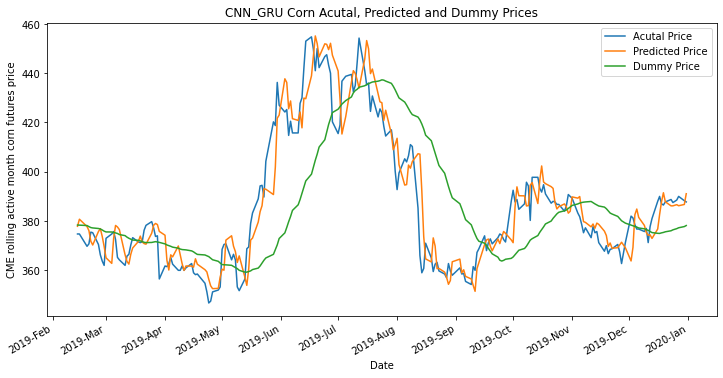

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

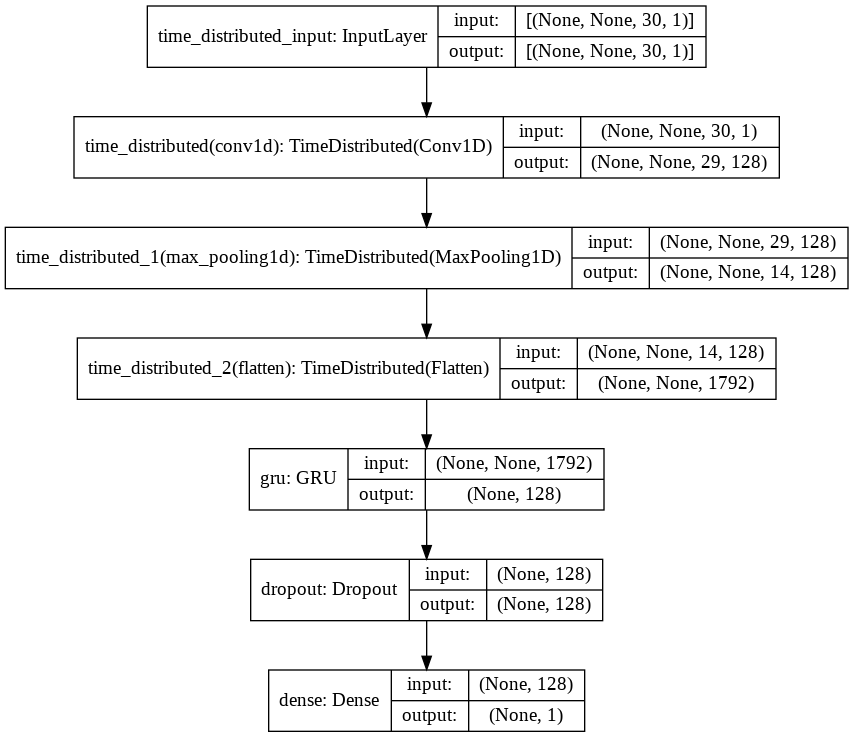

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.00738074603305581
RMSE:  0.08591126837066143
MAE:  0.06377510935898459
Dummy MSE:  0.041446864361575214
Dummy RMSE:  0.20358502980714277
Dummy MAE:  0.15160472972972977


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Corn/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Corn/assets
